# Deep Learning with Adversarial Examples

We have already learnt how to produce machine learning models, but is it safe to use the model?

Many researchers found that machine leanring models such as image classifiers are vulnerable to tiny perturbations to their inputs (adversarial attacks) that cause them to make the wrong decisions . 

Here are some examples:

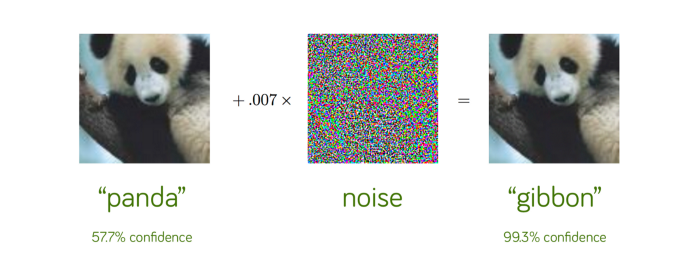


A panda image added a carefully contructed noice and make the neural network thinks it is an gibbon image.

<font size=1> image source: https://miro.medium.com/max/700/1*xvQ5Tvms6yi1crla1merXw.png </font>


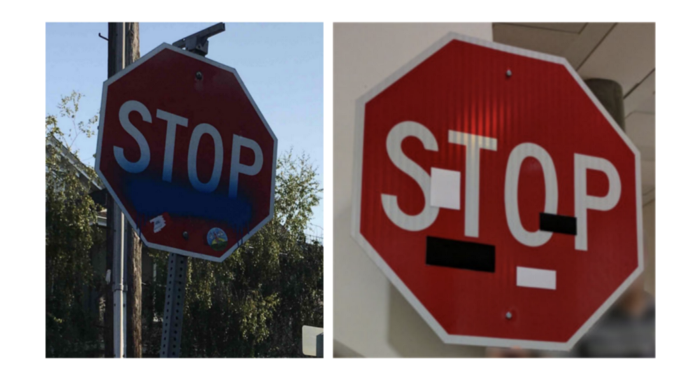

A physical perturbation applied to a stop sign make the systems classify the sign as a Speed Limit: 45 mph sign.

<font size=1> image source:
https://miro.medium.com/max/700/1*n18mfvFgeZTLVxx07iBNkA.png
</font>

Think about, in real life, if someone had placed a picture over a stop sign, which looks like a stop sign with a little dirt for humans, but a self-drving car may recognise it as another sign, such as a parking prohibition sign. Then, the self-driving car crashes into another car!!


## Adversarial Example

An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction. Adversarial examples are counterfactual examples with the aim to deceive the model, not interpret it.


## Adversarial Attacks

Designing an input in a specific way to get the wrong result from the model is called an adversarial attack.

## Fast Gradient Sign Attack

Fast gradient sign method is a computationally efficient method for generating adversarial examples. It perturbs an example in the direction of the sign of the gradient of the loss function w.r.t. the input:



\begin{align}x^* = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, x, y))\end{align}

where $x$ is an example, $y$ is the label of $x$, $J(θ,x,y)$ is the loss function used to generate adversarial examples, $x^∗$ is the perturbed example and $ϵ$  is a constant used to control the size of perturbations.

In other words, 

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) \end{align}

Finally, in order to maintain the original range of the data, the
perturbed image is clipped to range $[0,1]$.

### Implementation:

#### Import the required libraries

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn  
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
%matplotlib inline

#### FGSM method to generate perturbed images

In [2]:
# Input:
# model - model under attack
# images - original images in dataset
# labels - original labels, the ground truth, in dataset
# epsilon - constant used to control the size of perturbations
# Note: use nll_loss() for loss function in this example
def fgsm(model, images, labels, epsilon):
            
    # Set requires_grad attribute of tensor
    images.requires_grad = True
    
    # Forward pass the data through the model
    outputs = model(images)
            
    # Calculate the loss
    loss = F.nll_loss(outputs, labels)    
    
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect the element-wise sign of the gradient
    sign_data_grad = images.grad.data.sign()
   
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_images = images + epsilon*sign_data_grad
   
    # Adding clipping to maintain [0,1] range
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
   
    # Return the perturbed images
    return perturbed_images

#### Model Under Attack

CNN model to classify digits in MNIST dataset

In [3]:
# Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.fc1(x)
        return torch.log_softmax(x, dim=1)


# MNIST test dataset and dataloader declaration
transform = transforms.Compose([
    transforms.ToTensor(),
])

testset = datasets.MNIST('./data/', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=128)

# Initialize the network
model = Net()

# Load the pretrained model
# You may also train your own model for the attack
model.load_state_dict(torch.load('./data/MNIST-orig.pth'))


# Set the model in evaluation mode
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

### Test function

For each sample in the test set, the function computes the gradient of the
loss w.r.t the input data, creates a perturbed
image with ``fgsm`` , then checks to see
if the perturbed example is adversarial. In addition to testing the
accuracy of the model, the function also saves and returns some
successful adversarial examples to be visualized later.

In [4]:
def test(model, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = [] 

    # Loop over all examples in test set
    for data, labels in test_loader:
    
    
        # Call FGSM function      
        perturbed_data = fgsm(model, data, labels, epsilon)

        # Classify the perturbed image
        outputs = model(perturbed_data)      
        
        _, predicted = torch.max(outputs.data, 1)
    
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
            
        ############ Collect adversarial examples########################
        for i in range(labels.size(0)):
            if predicted[i] == labels[i]:                
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data[i].squeeze().detach().numpy()                  
                    adv_examples.append( (labels[i], predicted[i], adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data[i].squeeze().detach().numpy()                    
                    adv_examples.append( (labels[i], predicted[i], adv_ex) )
        #################################################################
        
    final_acc = float(correct) / total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))
    return final_acc, adv_examples
    

### Run the test

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9882 / 10000 = 0.9882
Epsilon: 0.05	Test Accuracy = 9458 / 10000 = 0.9458
Epsilon: 0.1	Test Accuracy = 8022 / 10000 = 0.8022
Epsilon: 0.15	Test Accuracy = 5086 / 10000 = 0.5086
Epsilon: 0.2	Test Accuracy = 1985 / 10000 = 0.1985
Epsilon: 0.25	Test Accuracy = 688 / 10000 = 0.0688
Epsilon: 0.3	Test Accuracy = 337 / 10000 = 0.0337


### Results

Accuracy vs Epsilon


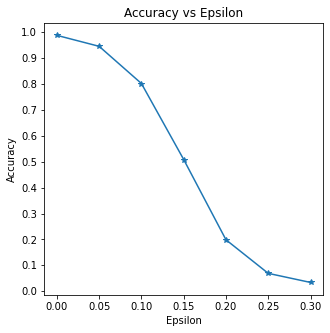

In [6]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Sample Adversarial Examples

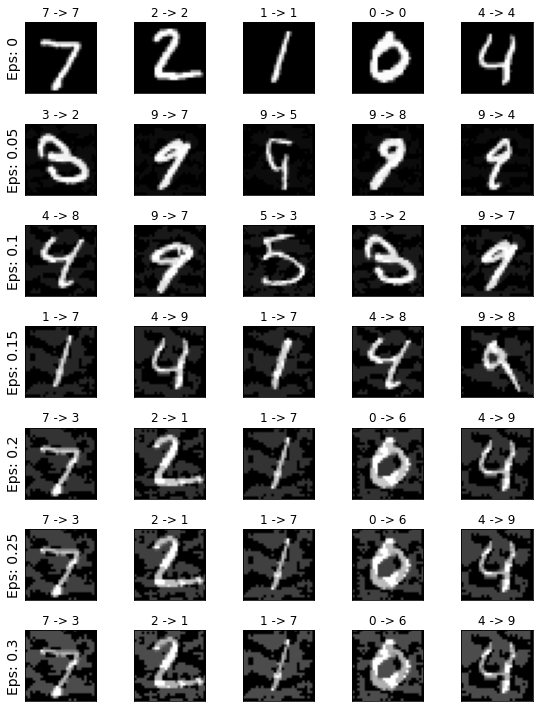

In [7]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# References

References
Adversarial example generation — PyTorch tutorials 1.6.0 documentation. (n.d.). PyTorch. https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

Adversarial Examples and Adversarial Training [Video]. (n.d.). YouTube. https://www.youtube.com/watch?v=CIfsB_EYsVI

Exploring adversarial training strategies with PGD attack. (n.d.). Po-Ming "Terrance" Law. https://terrancelaw.github.io/adversarial-training-web/

FGSM-pytorch. (2019, April 11). FGSM-pytorch. https://github.com/Harry24k/FGSM-pytorch/blob/master/FGSM.ipynb

Jain, A. (2019, March 31). The intuition behind adversarial attacks on neural networks. Medium. https://medium.com/mlreview/the-intuition-behind-adversarial-attacks-on-neural-networks-71fdd427a33b

Knagg, O. (2019, January 6). Know your enemy. Medium. https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3

Kolter, Z., & Madry, A. (n.d.). Chapter 3 - Adversarial examples, solving the inner maximization. Adversarial Robustness - Theory and Practice. https://adversarial-ml-tutorial.org/adversarial_examples/

Learning more robust features with adversarial training. (n.d.). arXiv. https://www.arxiv-vanity.com/papers/1804.07757/

Molnar, C. (2020, August 17). 6.2 adversarial examples | Interpretable machine learning. Christoph Molnar | Christoph Molnar Analytics. https://christophm.github.io/interpretable-ml-book/adversarial.html

Oscarknagg/adversarial. (n.d.). GitHub. https://github.com/oscarknagg/adversarial/blob/master/notebooks/Creating_And_Defending_From_Adversarial_Examples.ipynb

Yaodong Yu. (n.d.). TRADES (TRadeoff-inspired Adversarial DEfense via Surrogate-loss minimization). GitHub. https://github.com/yaodongyu/TRADES
